In [ ]:
import os
import time
import re
import easygui as eg
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
from selenium.common.exceptions import TimeoutException
from pdfreader import PDFDocument, SimplePDFViewer

# PIPELINE

### SETUP

You need to unzip `URGI_WHEAT.zip` in the `DatabasesTE` folder. URGI_WHEAT contains two files: once you have extracted the .zip, move both files directly into the `DatabasesTE` folder (see image below).

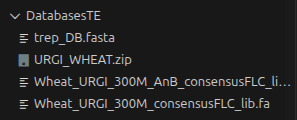

Then, you need to rename `Wheat_URGI_300M_consensusFLC_lib.fa` to `URGI_db.fa`, and move this new file into the `TE_DB` folder (see image below).

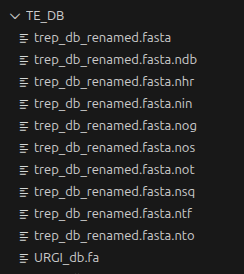

In [ ]:
# Changing the file IDs because BlastN is being a bully
MAX_LEN = 50
with open("TE_DB/URGI_db.fa") as inp, open("TE_DB/URGI_db1.fa", "w") as out:
    i = 1
    for line in inp:
        if line.startswith(">"):
            new_id = line[1:].strip()[:MAX_LEN-5]
            out.write(f">{new_id}_{i}\n")
            i += 1
        else:
            out.write(line)

In [ ]:
download_dir = "/home/crakshay/Téléchargements" 
# Your usual download folder (for WSL users, check the Downloads folder in the WSL storage section)
password = input("Your WSL/Linux password") # Your WSL / Linux password

# Never close the browser or the windows opened by the notebook until you are completely done!

### INTERACTIVE WINDOW

In [ ]:
# Interactive window for species choice 
species_str = [
    f"{scientific} : {short}"
    for short, scientific in [
        ('human', 'Homo sapiens'),
        ('fly', 'Drosophila melanogaster'),
        ('arabidopsis', 'Arabidopsis thaliana'),
        ('brugia', 'Brugia malayi'),
        ('aedes', 'Aedes aegypti'),
        ('tribolium', 'Tribolium castaneum'),
        ('schistosoma', 'Schistosoma mansoni'),
        ('tetrahymena', 'Tetrahymena thermophila'),
        ('galdieria', 'Galdieria sulphuraria'),
        ('maize', 'Zea mays'),
        ('toxoplasma', 'Toxoplasma gondii'),
        ('caenorhabditis', 'Caenorhabditis elegans'),
        ('(elegans)', 'Caenorhabditis elegans'),
        ('aspergillus_fumigatus', 'Aspergillus fumigatus'),
        ('aspergillus_nidulans', 'Aspergillus nidulans'),
        ('(anidulans)', 'Aspergillus nidulans'),
        ('aspergillus_oryzae', 'Aspergillus oryzae'),
        ('aspergillus_terreus', 'Aspergillus terreus'),
        ('botrytis_cinerea', 'Botrytis cinerea'),
        ('candida_albicans', 'Candida albicans'),
        ('candida_guilliermondii', 'Candida guilliermondii'),
        ('candida_tropicalis', 'Candida tropicalis'),
        ('chaetomium_globosum', 'Chaetomium globosum'),
        ('coccidioides_immitis', 'Coccidioides immitis'),
        ('coprinus', 'Coprinus cinereus'),
        ('coprinus_cinereus', 'Coprinus cinereus'),
        ('coyote_tobacco', 'Nicotiana attenuata'),
        ('cryptococcus_neoformans_gattii', 'Cryptococcus neoformans gattii'),
        ('cryptococcus_neoformans_neoformans_B', 'Cryptococcus neoformans neoformans'),
        ('cryptococcus_neoformans_neoformans_JEC21', 'Cryptococcus neoformans neoformans'),
        ('(cryptococcus)', 'Cryptococcus neoformans'),
        ('debaryomyces_hansenii', 'Debaryomyces hansenii'),
        ('encephalitozoon_cuniculi_GB', 'Encephalitozoon cuniculi'),
        ('eremothecium_gossypii', 'Eremothecium gossypii'),
        ('fusarium_graminearum', 'Fusarium graminearum'),
        ('(fusarium)', 'Fusarium graminearum'),
        ('histoplasma_capsulatum', 'Histoplasma capsulatum'),
        ('(histoplasma)', 'Histoplasma capsulatum'),
        ('kluyveromyces_lactis', 'Kluyveromyces lactis'),
        ('laccaria_bicolor', 'Laccaria bicolor'),
        ('lamprey', 'Petromyzon marinus'),
        ('leishmania_tarentolae', 'Leishmania tarentolae'),
        ('lodderomyces_elongisporus', 'Lodderomyces elongisporus'),
        ('magnaporthe_grisea', 'Magnaporthe grisea'),
        ('neurospora_crassa', 'Neurospora crassa'),
        ('(neurospora)', 'Neurospora crassa'),
        ('phanerochaete_chrysosporium', 'Phanerochaete chrysosporium'),
        ('(pchrysosporium)', 'Phanerochaete chrysosporium'),
        ('pichia_stipitis', 'Pichia stipitis'),
        ('rhizopus_oryzae', 'Rhizopus oryzae'),
        ('saccharomyces_cerevisiae_S288C', 'Saccharomyces cerevisiae'),
        ('saccharomyces_cerevisiae_rm11-1a_1', 'Saccharomyces cerevisiae'),
        ('(saccharomyces)', 'Saccharomyces cerevisiae'),
        ('schizosaccharomyces_pombe', 'Schizosaccharomyces pombe'),
        ('thermoanaerobacter_tengcongensis', 'Thermoanaerobacter tengcongensis'),
        ('trichinella', 'Trichinella spiralis'),
        ('ustilago_maydis', 'Ustilago maydis'),
        ('(ustilago)', 'Ustilago maydis'),
        ('yarrowia_lipolytica', 'Yarrowia lipolytica'),
        ('nasonia', 'Nasonia vitripennis'),
        ('tomato', 'Solanum lycopersicum'),
        ('chlamydomonas', 'Chlamydomonas reinhardtii'),
        ('amphimedon', 'Amphimedon queenslandica'),
        ('pneumocystis', 'Pneumocystis jirovecii'),
        ('wheat', 'Triticum aestivum'),
        ('chicken', 'Gallus gallus'),
        ('zebrafish', 'Danio rerio'),
        ('E_coli_K12', 'Escherichia coli'),
        ('s_aureus', 'Staphylococcus aureus'),
        ('volvox', 'Volvox carteri'),
    ]
]

msg ="Choose an identifier"
title = "Identifier | Species"
chosen_species = eg.choicebox(msg, title, species_str)
c_s = chosen_species.split(":")[1].replace(" ","")

# Interactive window for file selection
sequence = eg.fileopenbox(multiple=False)
file_name = os.path.basename(sequence).split(".")[0]
if not os.path.isdir(f"{c_s}_{file_name}"):
    os.system(f"mkdir {c_s}_{file_name}") # Creating a folder for the given sequence
os.chdir(f"{c_s}_{file_name}")


### SETTING UP SELENIUM

In [ ]:
os.system(f'echo {password} | sudo -S service tor stop')
os.system(f'echo {password} | sudo -S service tor start') # OH HELL NAH I'M NOT PAYING
opts = Options()
opts.headless = True
opts.set_preference("print.print_headerleft", "")
opts.set_preference("print.print_headerright", "")
opts.set_preference("print.print_footerleft", "")
opts.set_preference("print.print_footerright", "")

output_pdf = os.path.join(os.path.abspath(f"../{c_s}_{file_name}"), "result.pdf")
opts.set_preference("browser.helperApps.neverAsk.saveToDisk", "application/pdf")
opts.set_preference("print.always_print_silent", True)
opts.set_preference("print.print_to_file", True)
opts.set_preference("print.print_to_filename", output_pdf)
opts.set_preference("print_printer", "Mozilla Save to PDF")
opts.set_preference("print.printer_Mozilla_Save_to_PDF.print_to_file", True)
opts.set_preference("print.printer_Mozilla_Save_to_PDF.print_to_filename", output_pdf)
opts.set_preference("pdfjs.disabled", True) 

# Basically I don't want to pay so I change my proxy with Tor (Kinda illegal btw)
opts.set_preference("network.proxy.type", 1)
opts.set_preference("network.proxy.socks", "127.0.0.1")
opts.set_preference("network.proxy.socks_port", 9050)
opts.set_preference("network.proxy.socks_remote_dns", True)

###   TRANSPOSABLE ELEMENTS DETECTION AND SOFT MASKING 

#### With Blast

In [ ]:
if not os.path.isdir(f"TE"):
    os.system(f"mkdir TE")
os.chdir("../TE_DB")


# Using Blast with TrepDB to detect TE
os.system(f"makeblastdb -in trep_db_renamed.fasta -dbtype nucl -parse_seqids")
os.system(f"blastn -db trep_db_renamed.fasta -query {sequence} -outfmt 7 -out ../{c_s}_{file_name}/TE/Blast_TE_TREP_output7") 
os.system(f"blastn -db trep_db_renamed.fasta -query {sequence} -out ../{c_s}_{file_name}/TE/Blast_TE_TREP_output") 
print("Blast with TrepDB done.")

# Using Blast with URGIDB to detect TE
os.system(f"makeblastdb -in URGI_db1.fa -dbtype nucl -parse_seqids")
os.system(f"blastn -db URGI_db1.fa -query {sequence} -outfmt 7 -out ../{c_s}_{file_name}/TE/Blast_TE_URGI_output7") 
os.system(f"blastn -db URGI_db1.fa -query {sequence} -out ../{c_s}_{file_name}/TE/Blast_TE_URGI_output") 
print("Blast with URGI done.")

#### With Censor

In [ ]:
driver = webdriver.Firefox(options=opts)
driver.get("https://www.girinst.org/censor/")
driver.set_page_load_timeout(60)

# Choosing the taxon
name = chosen_species.split(":")[0][:-1]
name1 = name
if name == "Triticum aestivum":
    name = "Triticum"
driver.find_element(By.CSS_SELECTOR,"select[name='taxon']").click()
options = driver.find_elements(By.CSS_SELECTOR, "option")
for option in options:
    if name in option.text:
        option.click()
driver.find_element(By.CSS_SELECTOR, "div[id='content']").click()

# Okay time to submit the file
file_input = driver.find_element(By.CSS_SELECTOR, "input[type='file']")
file_input.send_keys(os.path.abspath(sequence))
driver.find_element(By.CSS_SELECTOR, "input[type='submit']").click()

# Waiting for the new page to load
time.sleep(5)
wait = WebDriverWait(driver, 40)
link = wait.until(
    EC.presence_of_element_located((By.XPATH, "//a[@href]"))
)
link.click()

# Saving the results
with open (f'../{c_s}_{file_name}/{file_name}_masked.fasta', 'w') as sq:
    sq.write(driver.find_element(By.CSS_SELECTOR, "pre").text) # OMG ? The masked sequence is here
driver.execute_script("window.print();")
os.chdir(f"../{c_s}_{file_name}")
time.sleep(7)
os.system(f"mv result.pdf TE")

# Perfect we detected the TE !
print("Softmasking + detection done.")

##############################################################################
## GMAN the .gff3 sorcerer (Georgy used his cursed technique to create the .gff3 files)

# Save CENSOR results table/page as txt
with open(f"../{c_s}_{file_name}/TE/censor_results.txt", "w", encoding="utf-8") as out:
    out.write(driver.find_element(By.TAG_NAME, "body").text)

# Sneaky ARTEMIS folder
if not os.path.isdir("ARTEMIS"):
    os.system("mkdir ARTEMIS")

# INPUT / OUTPUT
in_txt  = "TE/censor_results.txt"
out_gff = "ARTEMIS/TE_censor.gff3"

te_id = 0
with open(in_txt, "r", encoding="utf-8") as fin, open(out_gff, "w", encoding="utf-8") as fout:
    fout.write("##gff-version 3\n")

    for line in fin:
        line = line.strip()
        if not line:
            continue
        # stop when the masked sequence starts
        if line.startswith("Masked Sequence") or line.startswith(">"):
            break
        # skip headers
        if line.startswith(("Map of Hits", "SVG", "Name From To")):
            continue
        # expected row format (whitespace separated):
        # seqid from to name from2 to2 class dir sim pos/mm:ts score
        parts = re.split(r"\s+", line)
        if len(parts) < 11:
            continue  # not a hit row

        seqid   = parts[0]
        start   = int(parts[1])
        end     = int(parts[2])
        nom    = parts[3]
        teclass = parts[6]
        direction = parts[7]
        score   = parts[10]

        strand = "+" if direction == "d" else "-" if direction == "c" else "."
        te_id += 1
        attrs = f"ID=TE{te_id};Name={nom};Class={teclass}"
        fout.write(f"{seqid}\tCENSOR\ttransposable_element\t{start}\t{end}\t{score}\t{strand}\t.\t{attrs}\n")

print(".gff3 created for TEs.")
##############################################################################

### GENE PREDICTION + FGENESH

#### Augustus and FGENESH

##### Dedicated functions

In [ ]:
def augustus(masked: bool):
    # Using Augustus to predict genes
    folder = "augustus_pred"
    if masked :
        os.system(f"augustus --species={c_s} --codingseq=on --exonnames=on {file_name}_masked.fasta > augustus_pred_masked/augustus_result.txt")
        folder = "augustus_pred_masked"
        os.system('grep -v "^#" augustus_pred_masked/augustus_result.txt > ARTEMIS/augustus_masked_result.gff3')
    else:
        os.system(f"augustus --species={c_s} --codingseq=on --exonnames=on {sequence} > augustus_pred/augustus_result.txt")
        os.system('grep -v "^#" augustus_pred/augustus_result.txt > ARTEMIS/augustus_result.gff3')

    # Extracting every predicted proteins, predicted CDS and predicted genes
    with open(f"{folder}/augustus_result.txt", 'r', encoding='utf-8') as res:
        with open(f"{folder}/predicted_genes_by_augustus.txt", 'w', encoding="utf-8") as pred :
            prots = ""
            cds = ""
            gene_found, protein_found, CDS_found = False, False, False
            for line in res:
                if line.startswith("# start gene"):
                    gene_found = True
                if line.startswith("# end gene"):
                    pred.write(line)
                    gene_found = False
                if gene_found:
                    if line.startswith("# coding sequence"):
                        CDS_found = True
                    if line.startswith("# protein sequence"):
                        CDS_found = False
                        protein_found = True
                    if line.startswith("# Evidence "):
                        protein_found = False
                    pred.write(line)
                if CDS_found:
                    line = line.replace("coding sequence = ", "").replace("# ", "")
                    cds += line
                if protein_found:
                    line = line.replace("protein sequence = ", "").replace("# ", "")
                    prots += line

    # We'll use Blastp to check the protein predictions
    if not os.path.isdir(f"{folder}/predicted_proteins"):
        os.system(f"mkdir {folder}/predicted_proteins")

    # Creating .fasta files for proteins
    seqs = re.findall(r"\[(.*?)\]", prots, flags=re.DOTALL)
    gene_number = 0
    for seq in seqs : 
        gene_number += 1
        with open(f"{folder}/predicted_proteins/Protein{gene_number}.fasta", "w", encoding='utf-8') as pro :
            pro.write(f">Protein{gene_number}\n")
            pro.write(seq)

    # We'll use Blastn to check the mRNA predictions
    if not os.path.isdir(f"{folder}/predicted_mRNA"):
        os.system(f"mkdir {folder}/predicted_mRNA")

    # Creating .fasta files for mRNA
    seqs1 = re.findall(r"\[(.*?)\]", cds, flags=re.DOTALL)
    gene_number = 0
    for seq in seqs1 : 
        gene_number += 1
        with open(f"{folder}/predicted_mRNA/mRNA{gene_number}.fasta", "w", encoding='utf-8') as mrna :
            mrna.write(f">mRNA{gene_number}\n")
            mrna.write(seq)

def fgenesh(masked: bool):
    driver.get("http://www.softberry.com/berry.phtml?topic=fgenesh&group=programs&subgroup=gfind")
    folder = "FGENESH"
    suffix = "_"
    if masked:
        folder = "FGENESH_masked"
        suffix = "_m"

    # Submitting the fasta file
    file_input2 = driver.find_element(By.CSS_SELECTOR, "input[type='file']")
    if masked :
        file_input2.send_keys(os.path.abspath(f"{file_name}_masked.fasta"))
    else :
        file_input2.send_keys(os.path.abspath(f"{sequence}"))

    try:
        # Choosing the organism
        driver.find_element(By.XPATH, "//span[contains(text(), 'Organism')]").click()
        driver.find_element(By.CSS_SELECTOR, "input[tabindex='5']").send_keys(name)
        driver.find_element(By.CSS_SELECTOR, "li.active-result").click() # First result

        # Getting the .pdf file of the results
        driver.find_element(By.CSS_SELECTOR, "input[type='submit']").click()
        wait.until(
            EC.presence_of_element_located((By.XPATH, "//a[contains(text(), 'Show picture of predicted genes in PDF file')]"))
        ).click()
        download_dir = "/home/crakshay/Téléchargements"
        files = [os.path.join(download_dir, f) for f in os.listdir(download_dir)]
        latest_pdf = max(files, key=os.path.getmtime)
        os.system(f"mv {latest_pdf} {folder}")

        ##############################################################################
        ## GMAN comes back for the .gff3 (Georgy used his cursed technique again)

        # ADD: save FGENESH results page as html
        with open(f"{folder}/getfile.pdf", "w", encoding="utf-8") as out:
            out.write(driver.page_source)

        # ADD: save FGENESH results page as txt (plain text)
        with open(f"{folder}/fgenesh_results.txt", "w", encoding="utf-8") as out:
            out.write(driver.find_element(By.TAG_NAME, "body").text)

        # INPUT / OUTPUT
        folder = "FGENESH_masked" if masked else "FGENESH"
        in_txt = f"{folder}/fgenesh_results.txt"
        out_gff = f"ARTEMIS/fgenesh{'_masked' if masked else ''}_result.gff3"

        # Parsing FGENESH results to GFF3
        seqid = file_name
        genes = {}  # gid -> {"strand": "+/-", "cds":[(s,e),...], "extra":[positions]}

        with open(in_txt, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()

                # Seq name: region6
                m = re.search(r"Seq\s*name:\s*(\S+)", line)
                if m:
                    seqid = m.group(1)

                # CDS rows: "1 + 1 CDSi 123 - 474 ..."
                m = re.match(r"^(\d+)\s+([+-])\s+\d+\s+CDS\w+\s+(\d+)\s*-\s*(\d+)", line)
                if m:
                    gid = int(m.group(1))
                    strand = m.group(2)
                    s = int(m.group(3)); e = int(m.group(4))
                    if s > e: s, e = e, s
                    genes.setdefault(gid, {"strand": strand, "cds": [], "extra": []})
                    genes[gid]["cds"].append((s, e))
                    continue

                # Optional boundary points: "2 - TSS 8238" or "1 + PolA 3366"
                m = re.match(r"^(\d+)\s+([+-])\s+(TSS|PolA)\s+(\d+)", line)
                if m:
                    gid = int(m.group(1))
                    strand = m.group(2)
                    pos = int(m.group(4))
                    genes.setdefault(gid, {"strand": strand, "cds": [], "extra": []})
                    genes[gid]["extra"].append(pos)

        if seqid is None:
            seqid = "region"  # fallback if header missing

        os.makedirs("ARTEMIS", exist_ok=True)

        with open(out_gff, "w", encoding="utf-8") as g:
            g.write("##gff-version 3\n")
            for gid in sorted(genes):
                cds_list = sorted(genes[gid]["cds"])
                if not cds_list:
                    continue

                strand = genes[gid]["strand"]
                coords = [x for seg in cds_list for x in seg] + genes[gid]["extra"]
                gstart, gend = min(coords), max(coords)

                gene_id = f"fgenesh.g{gid}"
                mrna_id = f"{gene_id}.t1"

                g.write(f"{seqid}\tFGENESH\tgene\t{gstart}\t{gend}\t.\t{strand}\t.\tID={gene_id}\n")
                g.write(f"{seqid}\tFGENESH\tmRNA\t{gstart}\t{gend}\t.\t{strand}\t.\tID={mrna_id};Parent={gene_id}\n")

                for i, (s, e) in enumerate(cds_list, 1):
                    g.write(f"{seqid}\tFGENESH\texon\t{s}\t{e}\t.\t{strand}\t.\tID={mrna_id}.exon{i};Parent={mrna_id}\n")
                    g.write(f"{seqid}\tFGENESH\tCDS\t{s}\t{e}\t.\t{strand}\t0\tID={mrna_id}.cds{i};Parent={mrna_id}\n")

        print(f"FEGENESH .gff3 created")
        ############################################################################## 

        # Parsing the .pdf file of the results
        with open(f"{folder}/getfile.pdf", "rb") as f:
            viewer = SimplePDFViewer(f)
            doc = PDFDocument(f)
            whole_file = ""
            nb_pages = len(list(doc.pages()))+1
            for page in range(1, nb_pages): 
                viewer.navigate(page)
                viewer.render()
                whole_file += "".join(viewer.canvas.strings) + "\n"

        # Creating .fasta files for proteins and mRNA
        seqs = re.findall(r'>(FGENESH[^\n>]*)([\s\S]*?)(?=>FGENESH|$)', whole_file, flags=re.DOTALL)
        prot_number = 0
        mRNA_number = 0
        for seq in seqs : 
            if not 'mRNA' in seq[0]:
                with open(f"{folder}/predicted_proteins/FGENESH_prot{prot_number}{suffix}.fasta", "w", encoding='utf-8') as pro :
                    prot_number += 1
                    comma = seq[0].index(",")
                    try:
                        oof = seq[0].index("+", comma)
                    except:
                        oof = seq[0].index("-", comma)
                    se = seq[0][:oof+1] + "\n" + seq[0][oof+1:]
                    pro.write(f">{se+seq[1]}")
            else:
                with open(f"{folder}/predicted_mRNA/FGENESH_mRNA{mRNA_number}{suffix}.fasta", "w", encoding='utf-8') as mRNA :
                    mRNA_number += 1
                    comma = seq[0].index(",")
                    try:
                        oof = seq[0].index("+", comma)
                    except:
                        oof = seq[0].index("-", comma)
                    se = seq[0][:oof+1] + "\n" + seq[0][oof+1:]
                    mRNA.write(f">{se+seq[1]}")
    except:
        pass

##### Using Augustus and FGENESH

In [ ]:
# Using Augustus to predict genes and proteins
if not os.path.isdir("augustus_pred"): # Creating a folder for the predictions
    os.system("mkdir augustus_pred")
augustus(False)
if not os.path.isdir("augustus_pred_masked"): 
    os.system("mkdir augustus_pred_masked")
augustus(True)

# Using FGENESH to predict genes and proteins
use_fgenesh = eg.boolbox("Do you want to use FGENESH? (Plant Genome only !)", choices=("YES", "NO"))
if use_fgenesh:
    # Non softmasked
    if not os.path.isdir("FGENESH"):
        os.system("mkdir FGENESH")
    if not os.path.isdir("FGENESH/predicted_proteins"):
        os.system("mkdir FGENESH/predicted_proteins")
    if not os.path.isdir("FGENESH/predicted_mRNA"):
        os.system("mkdir FGENESH/predicted_mRNA")
    fgenesh(False)

    # Softmasked
    if not os.path.isdir("FGENESH_masked"):
        os.system("mkdir FGENESH_masked")
    if not os.path.isdir("FGENESH_masked/predicted_proteins"):
        os.system("mkdir FGENESH_masked/predicted_proteins")
    if not os.path.isdir("FGENESH_masked/predicted_mRNA"):
        os.system("mkdir FGENESH_masked/predicted_mRNA")
    fgenesh(True)
else :
    print("No prediction made by FGENESH")

print("Proteins and genes prediction done. Check the folders.")


### TE, mRNA & PROTEINS PREDICTIONS VALIDATION

In [ ]:
# Creating folders for the specific databases
if not os.path.isdir("blastp_results"): # Creating a folder for the predictions
    os.system("mkdir blastp_results")
if not os.path.isdir("blastp_results/nr"):
    os.system("mkdir blastp_results/nr")
if not os.path.isdir("blastp_results/swiss"):
    os.system("mkdir blastp_results/swiss")

if not os.path.isdir("blastn_results"): # Creating a folder for the mRNA predictions
    os.system("mkdir blastn_results")
if not os.path.isdir("blastx_result"): 
    # Creating a folder for overall protein sequences validation
    os.system("mkdir blastx_result")

#### Validation functions

In [ ]:
def blast(dr, fi, type, directory, BLOSUM, DATABASE):
    try:
        dr.get(f"https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blast{type}&PAGE_TYPE=BlastSearch&LINK_LOC=blasthome")
    except TimeoutException:
        dr.refresh()
    file_input1 = dr.find_element(By.CSS_SELECTOR, "input[type='file']")
    if type in "px":
        if type == "p":
            file_input1.send_keys(os.path.abspath(f"{directory}/predicted_proteins/{fi}"))
        if type == "x":
            file_input1.send_keys(os.path.abspath(fi))
        dr.find_element(By.CSS_SELECTOR,"select[name='DATABASE']").click()
        dr.find_element(By.CSS_SELECTOR, f"option[value='{DATABASE}']").click() # nr_cluster_seq / swissprot
        dr.find_element(By.CSS_SELECTOR, "button[class='usa-accordion-button']").click()
        dr.find_element(By.CSS_SELECTOR,"select[name='MATRIX_NAME']").click()
        dr.find_element(By.CSS_SELECTOR, f"option[value='{BLOSUM}']").click() #BLOSUM62
        dr.find_element(By.CSS_SELECTOR, "input[class='blastbutton']").click()
    else :
        # TSA = archive of computationally assembled transcript sequences from primary data such as ESTs and NGS.
        file_input1.send_keys(os.path.abspath(f"{directory}/predicted_mRNA/{fi}"))
        dr.find_element(By.CSS_SELECTOR,"select[name='DATABASE']").click()
        dr.find_element(By.CSS_SELECTOR, f"option[value='{DATABASE}']").click() # TSA
        dr.find_element(By.CSS_SELECTOR, "input[id='qorganism']").send_keys(name1)
        first_li = wait.until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "ul.ui-ncbiautocomplete-options li") # First result
            )
        )
        first_li.click()
        dr.find_element(By.CSS_SELECTOR, "input[class='blastbutton']").click()

def download(dr, file, destination, suffix):
    type_dl = ["SAM_SQ", "Text"]
    wait.until(
        EC.presence_of_element_located((By.XPATH, "//h1[contains(text(), 'results for')]"))
    )
    try :
        dr.find_element(By.XPATH, "//div[contains(text(), 'No significant similarity found')]")
    except:
        time.sleep(6)
        rid = dr.find_element(By.CSS_SELECTOR, "a[title='BLAST search request ID']").text
        dr.set_page_load_timeout(5)
        try:
            dr.get(f"https://blast.ncbi.nlm.nih.gov/Blast.cgi?RESULTS_FILE=on&RID={rid}&FORMAT_TYPE={type_dl[1]}&FORMAT_OBJECT=Alignment& \
               DESCRIPTIONS=100&ALIGNMENTS=100&CMD=Get&DOWNLOAD_TEMPL=Results_All&ADV_VIEW=on")
        except:
            files = [os.path.join(download_dir, f) for f in os.listdir(download_dir)]
            latest_file = max(files, key=os.path.getmtime)
            os.system(f'headn=$( head -n -2 {latest_file}) ; echo "$headn" > {latest_file}')
            os.system(f"mv {latest_file} {os.path.basename(file).split(".")[0]}{suffix}.txt")
            os.system(f"mv {os.path.basename(file).split(".")[0]}{suffix}.txt {destination}")
            #os.system(f"samtools view -bS '{destination}/{os.path.basename(file).split(".")[0]}{suffix}.sam' > ARTEMIS/{os.path.basename(file).split(".")[0]}{suffix}.bam")
            time.sleep(3)
            dr.set_page_load_timeout(120)

def validate_mRNA(file, directory, suffix):
    # Blasting with TSA database
    blast(driver, file, "n", directory, '', 'tsa_nt')
    # Getting the results
    download(driver, file, "blastn_results", suffix) 

def validate_proteins(file, directory, suffix):
    # Blasting with NR database
        # Blosum62
    blast(driver, file, "p", directory, 'BLOSUM62', 'nr_cluster_seq')
    driver.execute_script("window.open('');")  
    driver.switch_to.window(driver.window_handles[1])   

    # Blasting with Swissprot database
        # Blosum62
    blast(driver, file, "p", directory, 'BLOSUM62', 'swissprot')
    driver.execute_script("window.open('');")  

    # Getting the results
    driver.switch_to.window(driver.window_handles[0])
    download(driver, file, f"blastp_results/nr", suffix) # Blosum60
    driver.switch_to.window(driver.window_handles[1])
    download(driver, file, f"blastp_results/swiss", suffix) # Blosum60
    driver.switch_to.window(driver.window_handles[0]) 

##### Transposable Elements

The chunks here are dedicated to dotplots creation.

In [ ]:
if not os.path.isdir("TE/Dotplots"):
    os.system("mkdir TE/Dotplots")
if not os.path.isdir("TE/Fastas"):
    os.system("mkdir TE/Fastas")

# Extracting the TEs from the BlastN result
unique_keys = set()
with open("TE/Blast_TE_output7", "r") as f:
    for line in f:
        line = line.strip()
        if line.startswith(file_name): 
            parts = line.split()  
            # KEY=xxxx
            for part in parts:
                if part.startswith("KEY="):
                    key = part.split("=")[1]
                    unique_keys.add(key)

for key in unique_keys:
    os.system(f"awk '/^>.*KEY={key}/ {{print_flag=1}} /^$/ {{print_flag=0}} print_flag' ../DatabasesTE/trep_DB.fasta > TE/Fastas/{key}.fasta")

In [ ]:
os.getcwd()
# Unfortunately you have to find the corresponding ID manually... (Wheat_URGI_300M_AnB_consensusFLC_lib.classif)
censor_TE = [
    ("RIX-incomp_3b_Itr1_300M-B-G19874-Map4_reversed", "L1-384_TAe"),
    ("DXX_3b_Itr1_300M-B-G10043-Map20", "Mariner-N8_TAe"),
    ("RIX-comp_3b_Itr1_300M-B-G10532-Map3_reversed", "L1-N6_TAe"),
    ("DTX-incomp_3b_Itr1_300M-B-G11526-Map3_reversed", "MuDR-N38_TAe"),
    ("DXX_3b_Itr1_300M-B-G10364-Map18", "MuDR-92_TAe"),
    ("DTX-incomp_3b_Itr1_300M-B-G11326-Map10", "MuDR-84_TAe"),
    ("DXX_3b_Itr1_300M-B-G10364-Map18", "MuDR-39_TAe"),
    ("DXX_3b_Itr1_300M-B-G20147-Map1_reversed", "Mariner-N10_TAe"),
    ("DTX-incomp_3b_Itr1_300M-B-G1212-Map20", "EnSpm-24c_TAe"),
    ("DXX_3b_Itr1_300M-B-G11984-Map13_reversed", "MuDR-N69_TAe"),
    ("DTX-incomp_3b_Itr1_300M-B-R1051-Map4", "EnSpm-5h3_TAe"),
    ("DTX-incomp_3b_Itr1_300M-B-G12117-Map12_reversed", "MuDR-59N1_TAe"),
    ("RLX-comp_3b_Itr1_300M-B-G2272-Map9", "Copia-82_TAe")
]

for internal_id, common_name in censor_TE:
    command = (
        f"awk '/^>{internal_id}/ {{p=1; print; next}} "
        f"/^>/ {{p=0}} p' ../DatabasesTE/Wheat_URGI_300M_consensusFLC_lib.fa "
        f"> TE/Fastas/{common_name}.fasta"
    )
    os.system(command)

In [ ]:
# DOTPLOTSSSS
files = [os.path.join("TE/Fastas", f) for f in os.listdir("TE/Fastas")]
for fakufile in files:
    os.system(f"dotmatcher {fakufile} {sequence} -windowsize 35 -threshold 50 -graph png -goutfile {os.path.basename(fakufile).split(".")[0]} -gdirectory TE/Dotplots/")


##### Augustus

mRNA validation

In [ ]:
for file in os.listdir("augustus_pred/predicted_mRNA"):
    validate_mRNA(file, "augustus_pred", "_ap")

In [ ]:
for file in os.listdir("augustus_pred_masked/predicted_mRNA"):
    validate_mRNA(file, "augustus_pred", "_apm")

Protein validation

In [ ]:
for file in os.listdir("augustus_pred/predicted_proteins"):
    validate_proteins(file, "augustus_pred", "_ap")

In [ ]:
for file in os.listdir("augustus_pred_masked/predicted_proteins"):
    validate_proteins(file, "augustus_pred", "_apm")

##### FGENESH

mRNA validation

In [ ]:
if use_fgenesh:
    for file1 in os.listdir("FGENESH/predicted_mRNA"):
        validate_mRNA(file1, "FGENESH", "_fg")

In [ ]:
if use_fgenesh:
    for file1 in os.listdir("FGENESH_masked/predicted_mRNA"):
        validate_mRNA(file1, "FGENESH_masked", "_fgm")

Protein validation

In [ ]:
if use_fgenesh:
    for file1 in os.listdir("FGENESH/predicted_proteins"):
        validate_proteins(file1, "FGENESH", "_fg")

In [ ]:
if use_fgenesh:
        validate_proteins(file1, "FGENESH_masked", "_fgm")

### BlastX

In [ ]:
# Let's check if some proteins are missing...
blast(driver, sequence, "x", "", 'BLOSUM62', 'swissprot')
download(driver,sequence,"blastx_result", "_") 
print("BlastX done.")

### Results

In [ ]:
# Little correction
if use_fgenesh:
    if not os.path.isdir("pred_by_fgenesh"):
        os.system("mkdir pred_by_fgenesh")
    os.system("mv FGENESH pred_by_fgenesh")
    os.system("mv FGENESH_masked pred_by_fgenesh")

if not os.path.isdir("pred_by_augustus"):
    os.system("mkdir pred_by_augustus")
os.system("mv augustus_pred pred_by_augustus")
os.system("mv augustus_pred_masked pred_by_augustus")

In [ ]:
os.chdir("..")
if not os.path.isdir("Results"):
    os.system("mkdir Results")
os.system(f"mv {c_s}_{file_name} Results")

## ARTEMIS

You have to use every file contained in the ARTEMIS folder.

In [ ]:
os.system("art")